# Assignment 3.3

# Image Caption Retrieval Model

### 1. Data preprocessing

We will use Microsoft COCO (Common Objects in Context) data set to train our "Image Caption Retrieval Model". This data set consists of pretrained 10-crop VGG19 features (Neural codes) and its corresponding text caption. 


In [1]:
from __future__ import print_function

import os
import sys
import numpy as np
import pandas as pd
from collections import OrderedDict

DATA_PATH = 'data'
EMBEDDING_PATH = 'embeddings'
MODEL_PATH = 'models'

You will need to create above directories and locate data set provided in directory 'data'

#### Reading pairs of image (VGG19 features) - caption data

In [2]:
# DO NOT CHANGE BELOW CODE

import collections

np_train_data = np.load(os.path.join(DATA_PATH,'train_data.npy'))
np_val_data = np.load(os.path.join(DATA_PATH,'val_data.npy'))

train_data = collections.OrderedDict()
for i in range(len(np_train_data.item())):
    cap =  np_train_data.item()['caps']
    img =  np_train_data.item()['ims']
    train_data['caps'] = cap
    train_data['ims'] = img
    
val_data = collections.OrderedDict()
for i in range(len(np_val_data.item())):
    cap =  np_val_data.item()['caps']
    img =  np_val_data.item()['ims']
    val_data['caps'] = cap
    val_data['ims'] = img

In [3]:
# example of caption
print(train_data['caps'][0])
print(train_data['ims'].shape)
print(len(train_data['caps']))

b'a woman wearing a net on her head cutting a cake'
(10000, 4096)
50000


In [4]:
# example of pre-computed VGG19 features
print(val_data['ims'][0])
print(val_data['ims'].shape)
print(len(val_data['caps']))


[0.00109166 0.         0.         ... 0.         0.         0.        ]
(5000, 4096)
25000


#### Reading caption and information about its corresponding raw images from Microsoft COCO website

In [5]:
# DO NOT CHANGE BELOW CODE
# use them for your own additional preprocessing step
# to map precomputed features and location of raw images 

import json

with open(os.path.join(DATA_PATH,'instances_val2014.json')) as json_file:
    coco_instances_val = json.load(json_file)
    
with open(os.path.join(DATA_PATH,'captions_val2014.json')) as json_file:
    coco_caption_val = json.load(json_file)

#### Additional preprocessing

In [6]:
# create your own function to map pairs of precomputed features and filepath of raw images
# this will be used later for visualization part
# simple approach: based on matched text caption (see json file)


def get_features_from_filename(image_filename, features_data, caption_data):
    coco_annotations = coco_caption_val['annotations']
    coco_images = coco_caption_val['images']

    coco_img_index = None
    for annotation in coco_images:
        coco_filename = annotation['file_name']
        if image_filename == coco_filename:
            coco_img_index = annotation['id']
            break;
            
    possible_captions = []
    for annotation in coco_annotations:
        #print(annotation.keys())
        caption_img_id = annotation['image_id']
        if coco_img_index == caption_img_id:
            possible_captions.append(annotation['caption'])

    #print(possible_captions)
    selected_feature_id = None
    selected_caption = None
    for i, caption in enumerate(caption_data):
        caption = caption.decode('utf-8')
        #print(i, caption)
        #break
        for possible_caption in possible_captions:
            if possible_caption.endswith('.'):
                possible_caption = possible_caption[:-1]
            if caption.lower() == possible_caption.lower():
                selected_feature_id = i
                selected_caption = caption
                
        if selected_feature_id != None:
                break

        
    # (not needed anymore) map the selected feature id [i*5: (i+1)*5] to the actual id
    #feature_id, _ = divmod(selected_feature_id, 5)
    features_vector = features_data[selected_feature_id]
    #compare selected captions with captions from 
    return (features_vector, selected_feature_id, selected_caption)
    

from difflib import SequenceMatcher
    
def get_features_info(index, dataset_captions, dataset_images, coco_annotations, coco_images):
    #low_index = index*5
    #top_index = (index+1)*5
    caption = dataset_captions[index]
    str_caption = caption.decode('utf-8').strip()
    #print("str_caption: {}".format(str_caption))
    features_vector = dataset_images[index]
    img_id = None
    selected_caption = None
    
    for annotation in coco_annotations:
        coco_caption = annotation['caption']
        coco_caption = coco_caption.strip()
        if coco_caption.endswith('.'):
            coco_caption = coco_caption[:-1]
        if str_caption.lower() == coco_caption.lower():
            selected_caption = str_caption
            img_id = annotation['image_id']
            #print("\n*** Found image index for: {}\n".format(str_caption))
            break
        #if SequenceMatcher(None, str_caption.lower(), coco_caption.lower()).ratio() > 0.8:
        #    print("caption: <{}>".format(coco_caption))
    
    file_name = None
    coco_url = None
    for img_data in coco_images:
        if img_data['id'] == img_id:
            file_name = img_data['file_name']
            coco_url = img_data['coco_url']
            break
    
    return (file_name, coco_url, selected_caption, features_vector)
    


#### Build vocabulary index 

In [7]:
# DO NOT CHANGE BELOW CODE

def build_dictionary(text):

    wordcount = OrderedDict()
    for cc in text:
        words = cc.split()
        for w in words:
            if w not in wordcount:
                wordcount[w] = 0
            wordcount[w] += 1
    words = list(wordcount.keys())
    freqs = list(wordcount.values())
    sorted_idx = np.argsort(freqs)[::-1]
    

    worddict = OrderedDict()
    worddict['<pad>'] = 0
    worddict['<unk>'] = 1
    for idx, sidx in enumerate(sorted_idx):
        worddict[words[sidx]] = idx+2  # 0: <pad>, 1: <unk>
    

    return worddict

# use the resulting vocabulary index as your look up dictionary
# to transform raw text into integer sequences

all_captions = []
all_captions = train_data['caps'] + val_data['caps']

# decode bytes to string format
caps = []
for w in all_captions:
    caps.append(w.decode())
    
words_indices = build_dictionary(caps)
print ('Dictionary size: ' + str(len(words_indices)))
indices_words = dict((v,k) for (k,v) in words_indices.items())

Dictionary size: 11473


### 2. Image - Caption Retrieval Model

In [8]:
from keras.layers import Input, Dense, Embedding, LSTM, Lambda, dot
from keras.models import Model, Sequential
from keras import backend as K
#from keras.layers import Input, Conv2D, Lambda, Dense, Flatten, MaxPooling2D, Dropout, BatchNormalization
#from keras.models import Model, Sequential


/home/mathyn/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Image model

In [9]:
# YOUR CODE HERE 
image_input = Input(shape=(4096, ))

image_model = Sequential()
image_model.add(Dense(1024, input_shape=(4096, ), name="image_neural_codes", activation="sigmoid"))
image_model.summary()

image_encoding = image_model(image_input)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_neural_codes (Dense)   (None, 1024)              4195328   
Total params: 4,195,328
Trainable params: 4,195,328
Non-trainable params: 0
_________________________________________________________________


### Caption model

In [10]:
# function to load pretrained embedding
def load_embedding(vocab, dimension, filename):
    print('loading embeddings from "%s"' % filename, file=sys.stderr)
    embedding = np.zeros((max(vocab.values()) + 1, dimension), dtype=np.float32)
    seen = set()
    with open(filename) as fp:
        for line in fp:
            tokens = line.strip().split(' ')
            if len(tokens) == dimension + 1:
                word = tokens[0]
                if word in vocab:
                    embedding[vocab[word]] = [float(x) for x in tokens[1:]]
                    seen.add(word)
                    if len(seen) == len(vocab):
                        break
    return embedding

In [11]:
weights = load_embedding(words_indices, 100, os.path.join(DATA_PATH,'glove.6B.100d.txt'))

loading embeddings from "data/glove.6B.100d.txt"


In [12]:
weights.shape

(11473, 100)

In [13]:
# YOUR CODE HERE
caption_max_length = 50
embedding_size = 100
rnn_output_units = 1024
# For embedding layer, initialize with pretrained word embedding (GloVe)
caption_input = Input(shape=(caption_max_length, ), name='input_layer', dtype='int32')
noisy_input = Input(shape=(caption_max_length, ),  name='noisy_input_layer', dtype='int32')

caption_model = Sequential()
caption_model.add(Embedding(len(words_indices), embedding_size, weights=[weights], input_length=caption_max_length, \
                            trainable=False, name='word_embedding'))
caption_model.add(LSTM(rnn_output_units, name='caption_neural_codes'))
# cts image and text (caption) in the same representation space. To buildthis model, you need two (2) sub models:  model for encoding image and model for encoding textas shown in figure 1.  You also need to train the model so that an image is c
#model = Sequential()
#model.add(Lambda(binarize, output_shape=binarize_outshape,name='char_embedding', \
#                 input_shape=(max_sequence_length,), dtype='int32'))
#model.add(LSTM(rnn_dim, name='lstm_layer'))
#model.add(Dense(1 , name='prediction_layer', activation='sigmoid'))




## the input lenght of the embedding layer corresponds to the lenght of the encoded text sequences
## which have a maximum of 50 words
#embedding_layer = Embedding(len(words_indices), embedding_size, weights=[weights], input_length=caption_max_length, \
#                            trainable=False, name='word_embedding')
#embedded_captions = embedding_layer(caption_input)
#lstm_layer = LSTM(rnn_output_units, name='caption_neural_codes')(embedded_captions)
print(caption_model.summary())
caption_encoding = caption_model(caption_input)
noisy_encoding = caption_model(noisy_input)
#print(caption_encoding.summary())
#print(noisy_encoding.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_embedding (Embedding)   (None, 50, 100)           1147300   
_________________________________________________________________
caption_neural_codes (LSTM)  (None, 1024)              4608000   
Total params: 5,755,300
Trainable params: 4,608,000
Non-trainable params: 1,147,300
_________________________________________________________________
None


### Join model

In [14]:
K.print_tensor(image_encoding)
K.print_tensor(caption_encoding)

<tf.Tensor 'Print_1:0' shape=(?, 1024) dtype=float32>

In [15]:
# YOUR CODE HERE
# dot_product = lambda x: K.dot(x[0], K.transpose(x[1]))
# dot_product = lambda x: K.dot(x[0], x[1])
# positive_examples = Lambda(dot_product)([image_encoding, caption_encoding])
# ## think about how to implement this
# negative_examples = Lambda(dot_product)([image_encoding, noisy_encoding])
# layer for computing dot product between tensors
positive_examples = dot([image_encoding, caption_encoding], axes=-1)
negative_examples = dot([image_encoding, noisy_encoding], axes=-1)


### Main model for training stage

In [16]:
# YOUR CODE HERE

# define your model input and output

print ("loading the training model")
training_model = Model(inputs=[image_input, caption_input, noisy_input], outputs=[positive_examples, negative_examples])

loading the training model


### Retrieval model

In [17]:
# YOUR CODE HERE

# define your model input and output

print ("loading sub-models for retrieving Neural codes")
caption_model = Model(inputs=caption_input, outputs=caption_encoding)
image_model = Model(inputs=image_input, outputs=image_encoding)

loading sub-models for retrieving Neural codes


### Loss function

We define our loss function as a loss for maximizing the margin between a positive and
negative example.  If we call $p_i$ the score of the positive pair of the $i$-th example, and $n_i$ the score of the negative pair of that example, the loss is:

\begin{equation*}
loss = \sum_i{max(0, 1 -p_i + n_i)}
\end{equation*}

In [18]:
from keras import backend as K


def max_margin_loss(y_true, y_pred):
#     K.print_tensor(y_true)
#     K.print_tensor(y_pred)
    loss_ = K.sum(K.maximum(0., 1. - y_pred[0] + y_pred[1]))
    #loss_ = K.sum(K.maximum(0., 1. - y_true + y_pred))
    
    return loss_
   

#### Accuracy metric for max-margin loss
How many times did the positive pair effectively get a higher value than the negative pair?

In [19]:
# YOUR CODE HERE
def accuracy(y_true, y_pred):
    # this line is used to debug the dimensions of y_pred[0]
    #return K.sum(K.maximum(0., 1. - y_pred[0] + y_true))

    # positive values take position 1 and negative position 0
    return K.mean(K.argmax((y_pred[1], y_pred[0]), axis=1))
    #return K.mean(K.max(K.round(y_pred[0] - y_pred[1] + 0.5), 0))


### Compile model

In [20]:
# DO NOT CHANGE BELOW CODE
print ("compiling the training model")
training_model.compile(optimizer='adam', loss=max_margin_loss, metrics=['acc', accuracy])

compiling the training model


### 3. Data preparation for training the model

* adjust the length of captions into fixed maximum length (50 words)
* sampling caption for each image, while shuffling the image data
* encode captions into integer format based on look-up vocabulary index

In [21]:
print(train_data['caps'][0:10])
print(train_data['ims'][:2])

[b'a woman wearing a net on her head cutting a cake', b'a woman cutting a large white sheet cake', b'a woman wearing a hair net cutting a large sheet cake', b'there is a woman that is cutting a white cake', b'a woman marking a cake with the back of a chefs knife', b'a young boy standing in front of a computer keyboard', b'a little boy wearing headphones and looking at a computer monitor', b'he is listening intently to the computer at school', b'a young boy stares up at the computer monitor', b'a young kid with head phones on using a computer']
[[0.00495117 0.         0.         ... 0.         0.00079085 0.01148911]
 [0.00460475 0.02057743 0.01465815 ... 0.         0.         0.02613593]]


In [22]:
# sampling one caption per image
# return image_ids, caption_ids
import random

def sampling_img_cap(data):

    # YOUR CODE HERE
    # first sample for each image a caption
    pairs_ids = []
    
    for image_id in range(len(data['ims'])):
        caption_delta = random.randint(0, 4)
        caption_id = image_id*5 + caption_delta
        pairs_ids.append((image_id, caption_id))

    # then shuffle the image data with the corresponding captions
    random.shuffle(pairs_ids)
    image_ids, caption_ids = zip(*pairs_ids)
    
    return image_ids, caption_ids


In [23]:
# transform raw text caption into integer sequences of fixed maximum length
from keras.preprocessing import sequence

def prepare_caption(caption_ids, caption_data):
    
    # YOUR CODE HERE
    selected_captions = []
    for i in caption_ids:
        caption_text = caption_data[i]
        caption_tokens = [words_indices[w] if w in words_indices.keys() else words_indices['<unk>'] for w in caption_text]
        selected_captions.append(caption_tokens)
        
    selected_captions_arr = np.array(selected_captions)        
    caption_seqs = sequence.pad_sequences(selected_captions_arr, maxlen=caption_max_length, value=0)
      
    return caption_seqs

In [24]:
# DO NOT CHANGE BELOW CODE

train_caps = []
for cap in train_data['caps']:
    train_caps.append(cap.decode())

val_caps = []
for cap in val_data['caps']:
    val_caps.append(cap.decode())

In [25]:
# DO NOT CHANGE BELOW CODE

train_image_ids, train_caption_ids = sampling_img_cap(train_data)
val_image_ids, val_caption_ids = sampling_img_cap(val_data)

x_caption = prepare_caption(train_caption_ids, train_caps)
x_image = train_data['ims'][np.array(train_image_ids)]

x_val_caption = prepare_caption(val_caption_ids, val_caps)
x_val_image = val_data['ims'][np.array(val_image_ids)]

In [26]:
print(val_data['caps'][val_caption_ids[0]], val_data['caps'][val_caption_ids[1]])
#print(train_data['caps'][:2])

sample_train_caption = [train_data['caps'][x] for x in train_caption_ids]
sample_val_caption = [val_data['caps'][x] for x in val_caption_ids]

print(sample_train_caption[0:2])
print(sample_val_caption[0:2])


# debug implementation of get_features_info

print(len(x_val_image))
print(len(sample_val_caption))

for i in range(5):
    image_info = get_features_info(i, sample_val_caption, x_val_image,
                                   coco_caption_val['annotations'], coco_caption_val['images'])
    print(image_info)

b'a park with several vehicles parked on the grass' b'a large number of donuts of different varieties with labels'
[b'a giraffe is standing in a grassy plain', b'a computer desk with an old pc and lots of clutter']
[b'a park with several vehicles parked on the grass', b'a large number of donuts of different varieties with labels']
5000
5000
('COCO_val2014_000000530470.jpg', 'http://images.cocodataset.org/val2014/COCO_val2014_000000530470.jpg', 'a park with several vehicles parked on the grass', array([0.00263283, 0.03362042, 0.00593199, ..., 0.01630132, 0.        ,
       0.        ], dtype=float32))
('COCO_val2014_000000073045.jpg', 'http://images.cocodataset.org/val2014/COCO_val2014_000000073045.jpg', 'a large number of donuts of different varieties with labels', array([0., 0., 0., ..., 0., 0., 0.], dtype=float32))
('COCO_val2014_000000041247.jpg', 'http://images.cocodataset.org/val2014/COCO_val2014_000000041247.jpg', 'ocean view of surfers waiting for a wave', array([0.        , 0.0

### 4. Create noise set for negative examples of image-fake caption and dummy output

Notice that we do not have real output with labels for training the model. Keras architecture expects labels, so we need to create dummy output -- which is numpy array of zeros. This dummy labels or output is never used since we compute loss function based on margin between positive examples (image-real caption) and negative examples (image-fake caption).

In [27]:
print(x_caption[0].shape)
print(len(words_indices))
print(x_caption[0])
ids = np.random.choice(x_caption[0].shape[0], 10, replace=False)
print(ids)


(50,)
11473
[    0     0     0     0     0     0     0     0     0     0     0     2
     1  6096  1010  6050     2 10788 10788  5035     1  1010  1867     1
  1867  1315     2  3512  3995  1010  3512  6096     1  1010  3512     1
     2     1  6096  6050     2  1867  1867  5452     1  6453  4107     2
  1010  3512]
[11 37 34 12  9 45 31 21 35 18]


In [28]:
x_caption

array([[    0,     0,     0, ...,     2,  1010,  3512],
       [    2,     1,  5632, ...,  1315,  5035,  6050],
       [ 5632,  1315,  8894, ...,  4107,  2086,  1315],
       ...,
       [    1,  5632,  2086, ..., 10788,  5035,  5035],
       [ 3512,  5452,     1, ...,  5035,  1315,  1867],
       [ 4107,  5035,  6453, ...,  2086,     2,  3995]], dtype=int32)

In [29]:
# YOUR CODE HERE
def generate_noisy_caption(caption):
    ids = np.random.choice(caption.shape[0], 20, replace=False)
    values = np.random.choice(len(words_indices), 20)
    #print(values)
    #print(caption)
    new_caption = caption
    #print(new_caption)
    
    #for i in range
    for i, val in zip(ids, values):
        new_caption[i] = val
    
    return new_caption
    
#print(generate_noisy_caption(x_caption[0]))
    
def generate_noisy_captions(images, captions):
    noisy_captions = np.empty(captions.shape, dtype=np.int32)
    
    i = 0
    for img, caption in zip(images, captions):
        noisy_caption = generate_noisy_caption(caption)
        noisy_captions[i, :] = noisy_caption
        i += 1
    
    return noisy_captions

#print(x_caption[:2])
#print(generate_noisy_captions(x_image[:2], x_caption[:2]))

train_noise = generate_noisy_captions(x_image, x_caption)
val_noise = generate_noisy_captions(x_val_image, x_val_caption)

y_train_labels = np.zeros((len(x_image), rnn_output_units))
y_val_labels = np.zeros((len(x_val_image), rnn_output_units))

In [30]:
train_noise

array([[    0,     0,     0, ...,     2,   765,   969],
       [ 2505,     1,  5632, ...,  1315,  5035,  6050],
       [ 9336,  1903,  1587, ...,  4107,  2086,  1315],
       ...,
       [11228,  5632,  2086, ..., 10788,  5521,  5035],
       [ 3512,  5452,   913, ..., 10437,  1315,  1867],
       [ 4930,  3724,  6453, ...,  2086,  6135,  3995]], dtype=int32)

In [31]:
x_caption

array([[    0,     0,     0, ...,     2,   765,   969],
       [ 2505,     1,  5632, ...,  1315,  5035,  6050],
       [ 9336,  1903,  1587, ...,  4107,  2086,  1315],
       ...,
       [11228,  5632,  2086, ..., 10788,  5521,  5035],
       [ 3512,  5452,   913, ..., 10437,  1315,  1867],
       [ 4930,  3724,  6453, ...,  2086,  6135,  3995]], dtype=int32)

In [32]:
print(y_train_labels.shape)
print(y_val_labels.shape)

(10000, 1024)
(5000, 1024)


### 5. Training model

In [33]:
# YOUR CODE HERE
print(x_image.shape)
print(x_caption.shape)
print(train_noise.shape)
print(y_train_labels.shape)

X_train = [x_image, x_caption, train_noise]
Y_train = [y_train_labels, y_train_labels]
X_valid = [x_val_image, x_val_caption, val_noise]
Y_valid = [y_val_labels, y_val_labels]

(10000, 4096)
(10000, 50)
(10000, 50)
(10000, 1024)


In [34]:
# YOUR CODE HERE
training_model.fit(X_train, Y_train, batch_size=128, validation_data=(X_valid, Y_valid), epochs=10)
# fit the model on training and validation set

Train on 10000 samples, validate on 5000 samples
Epoch 1/10
10000/10000 [==============================] - 568s 57ms/step - loss: 10.0106 - dot_1_loss: 5.0053 - dot_2_loss: 5.0053 - dot_1_acc: 0.0079 - dot_1_accuracy: 0.0000e+00 - dot_2_acc: 0.0079 - dot_2_accuracy: 0.0000e+00 - val_loss: 8.5858 - val_dot_1_loss: 4.2929 - val_dot_2_loss: 4.2929 - val_dot_1_acc: 0.0000e+00 - val_dot_1_accuracy: 0.0000e+00 - val_dot_2_acc: 0.0000e+00 - val_dot_2_accuracy: 0.0000e+00
Epoch 2/10
10000/10000 [==============================] - 567s 57ms/step - loss: 5.3502 - dot_1_loss: 2.6751 - dot_2_loss: 2.6751 - dot_1_acc: 0.0000e+00 - dot_1_accuracy: 0.0000e+00 - dot_2_acc: 0.0000e+00 - dot_2_accuracy: 0.0000e+00 - val_loss: 4.3826 - val_dot_1_loss: 2.1913 - val_dot_2_loss: 2.1913 - val_dot_1_acc: 0.0000e+00 - val_dot_1_accuracy: 0.0000e+00 - val_dot_2_acc: 0.0000e+00 - val_dot_2_accuracy: 0.0000e+00
Epoch 3/10
10000/10000 [==============================] - 541s 54ms/step - loss: 4.3676 - dot_1_loss: 2.

#### Storing models and weight parameters

In [49]:
# DO NOT CHANGE BELOW CODE

# Save model
training_model.save(os.path.join(MODEL_PATH,'image_caption_model.h5'))
# Save weight parameters
training_model.save_weights(os.path.join(MODEL_PATH, 'weights_image_caption.hdf5'))

# Save model for encoding caption and image
caption_model.save(os.path.join(MODEL_PATH,'caption_model.h5'))
image_model.save(os.path.join(MODEL_PATH,'image_model.h5'))

### 6. Feature extraction (Neural codes)

In [50]:
# YOUR CODE HERE

# Use caption_model and image_model to produce "Neural codes" 
# for both image and caption from validation set
val_image_codes = image_model.predict(x_val_image)
val_caption_codes = caption_model.predict(x_val_caption)

In [51]:
print(val_image_codes.shape)
print(val_caption_codes.shape)

(5000, 1024)
(5000, 1024)


### 7. Caption Retrieval

#### Display original image as query and its ground truth caption

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing import image

#print(coco_caption_val['images'][:5])
#print(val_data.keys())

a large red bag on the ground in a room


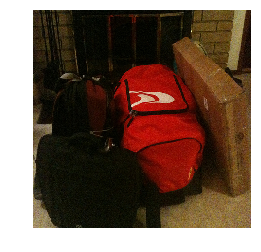

In [57]:
# YOUR CODE HERE

# choose one image_id from validation set
# use this id to get filepath of image
img_id = 16
filepath_image, coco_url, original_caption, _ = get_features_info(img_id, sample_val_caption, x_val_image,
                                                   coco_caption_val['annotations'], coco_caption_val['images'])

# display original caption
#original_caption = 
print(original_caption)
IMAGE_DATA = DATA_PATH + "/val2014"

# DO NOT CHANGE BELOW CODE
img = image.load_img(os.path.join(IMAGE_DATA,filepath_image), target_size=(224,224))
plt.imshow(img)
plt.axis("off")
plt.show()

In [58]:
print("Debug prints")
print(get_features_from_filename(filepath_image, x_val_image, sample_val_caption))
print(val_caption_ids[15])
print(x_val_image[15])

Debug prints
(array([0.0001816 , 0.        , 0.        , ..., 0.        , 0.00409039,
       0.        ], dtype=float32), 16, 'a large red bag on the ground in a room')
2391
[0.01488274 0.0372797  0.02771625 ... 0.         0.01861667 0.        ]


In [59]:
# define the knn model
from sklearn.neighbors import NearestNeighbors

images_nn = NearestNeighbors(n_neighbors=11, p=2)
images_nn.fit(val_image_codes)

# function to retrieve caption, given an image query
def get_caption(image_filename, image_codes = val_image_codes, n=10):
    features, features_id, selected_caption = get_features_from_filename(image_filename, image_codes, sample_val_caption)
    #print(features)
    print(selected_caption)
    similarity_scores, nn_ids = images_nn.kneighbors(np.array([features]))
    print(similarity_scores)
    print(nn_ids[0])
    selected_captions = []
    for nn_id in nn_ids[0]:
        caption_id = val_caption_ids[nn_id]
        selected_captions.append(val_data['caps'][caption_id])
    # YOUR CODE HERE
    return selected_captions
    

In [60]:
# DO NOT CHANGE BELOW CODE
get_caption(filepath_image)

a large red bag on the ground in a room
[[0.         0.33052029 0.33634902 0.34677813 0.35389499 0.35474189
  0.3671275  0.36983367 0.37073702 0.37442621 0.37607589]]
[  16 1624 3548 2115 2852 2300 1737 1477  209 1233 3712]


[b'a large red bag on the ground in a room',
 b'a man snuggled up to another man under the covers in a bed',
 b'a girl sitting on a sofa in front of a laptop',
 b'a dog wearing a protective head piece looking at a tv',
 b'a teddy bear holding a gun aimed at a stuffed sheep',
 b'girl kneeling on bed cluttered with stuffed animals',
 b'a young boy sitting on a wooden chair with a teddy bear',
 b'a bedroom filled with furniture and a bed',
 b'a bedroom has a regular bed and baby bed full of stuffed animals',
 b'a person laying on top of a bed',
 b'a cat on a couch in front of a laptop']

Briefly discuss the result. Why or how it works, and why do you think it does not work at some point.

#### Answer:

=== write your answer here ===

### 8. Image Retrieval

In [61]:
# given text query, display retrieved image, similarity score, and its original caption 

captions_nn = NearestNeighbors(n_neighbors=10, p=2)
captions_nn.fit(val_caption_codes)

def encode_text(caption_text):
    selected_captions = []
    caption_tokens = [words_indices[w] if w in words_indices.keys() else words_indices['<unk>'] for w in caption_text]
    selected_captions.append(caption_tokens)
        
    selected_captions_arr = np.array(selected_captions)        
    caption_seqs = sequence.pad_sequences(selected_captions_arr, maxlen=caption_max_length, value=0)
    
    caption_codes = caption_model.predict(caption_seqs)
    #print(caption_codes)
    return caption_codes


def search_image(text_caption, n=10):
    #print(text_caption)
    encoded_caption = encode_text(text_caption)
    
    #print(encoded_caption)
    similarity_scores, nn_ids = captions_nn.kneighbors(np.array(encoded_caption))
    #print(nn_ids)
    selected_images = []
    selected_captions = []
    for nn_id in nn_ids[0]:
        selected_caption = sample_val_caption[nn_id]
        selected_captions.append(selected_caption)
        filepath_image, _, _, _ = get_features_info(nn_id, sample_val_caption, x_val_image, 
                                                    coco_caption_val['annotations'], 
                                                    coco_caption_val['images'])
        selected_images.append(filepath_image)
        
    #print(selected_images)
    #print(selected_captions)

    for image_filename, caption in zip(selected_images, selected_captions):
        img = image.load_img(os.path.join(IMAGE_DATA,image_filename), target_size=(224,224))
        plt.imshow(img)
        plt.axis("off")
        plt.show()
        print(caption)

Consider to use the following settings for image retrieval task.

* use real caption that is available in validation set as a query.
* use part of caption as query. For instance, instead of use the whole text sentence of the
caption, you may consider to use key phrase or combination of words that is included in
corresponding caption.

In [62]:
print(sample_val_caption[15])

print(get_features_info(3719, sample_val_caption, x_val_image, coco_caption_val['annotations'], coco_caption_val['images']))

b'a kid is playing the nintendo wii'
('COCO_val2014_000000021889.jpg', 'http://images.cocodataset.org/val2014/COCO_val2014_000000021889.jpg', 'a man in a safety suit walking along the edge of a dog where a cruise ship is docked', array([0.        , 0.03231362, 0.00247053, ..., 0.00043152, 0.00424129,
       0.        ], dtype=float32))


In [63]:
## look similar captions
def similar_captions(caption):
    coco_annotations = coco_caption_val['annotations']

    coco_img_index = None
    for annotation in coco_images:
        coco_filename = annotation['file_name']
        if image_filename == coco_filename:
            coco_img_index = annotation['id']            
            break;
            
    possible_captions = []
    for annotation in coco_annotations:
        #print(annotation.keys())
        caption_img_id = annotation['image_id']
        if coco_img_index == caption_img_id:
            possible_captions.append(annotation['caption'])

    #print(possible_captions)
    selected_feature_id = None
    selected_caption = None
    for i, caption in enumerate(caption_data):
        caption = caption.decode('utf-8')
        #print(i, caption)
        #break
        for possible_caption in possible_captions:
            if possible_caption.endswith('.'):
                possible_caption = possible_caption[:-1]
            if caption.lower() == possible_caption.lower():
                selected_feature_id = i
                selected_caption = caption
                
        if selected_feature_id != None:
                break

        
    # (not needed anymore) map the selected feature id [i*5: (i+1)*5] to the actual id
    #feature_id, _ = divmod(selected_feature_id, 5)
    features_vector = features_data[selected_feature_id]
    #compare selected captions with captions from 
    return (features_vector, selected_feature_id, selected_caption)


ocean view of surfers waiting for a wave


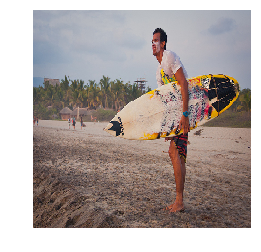

b'the surfer is ready to catch a big wave'


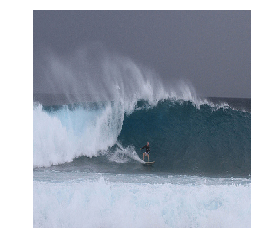

b'a person on a surf board by a big wave'


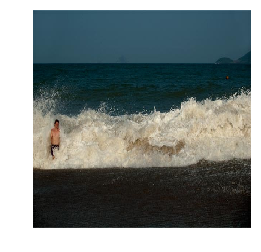

b'a man in the ocean being slammed by a wave'


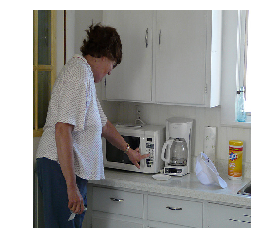

b'a woman is touching the buttons on a microwave'


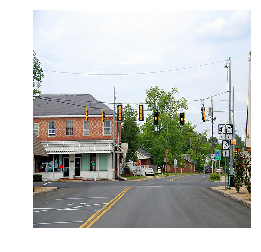

b'an intersection of streets with stop lights hanging above'


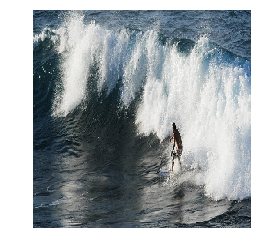

b'a surfer is standing on his board just in front of the wave'


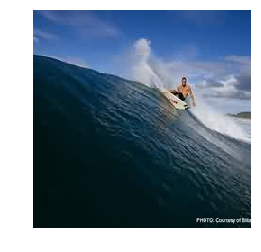

b'a man rides a surfboard on a large wave'


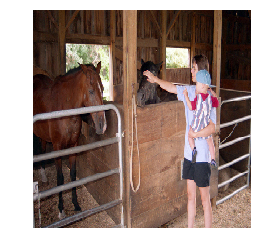

b'a person holding a baby is looking at horses in a stable'


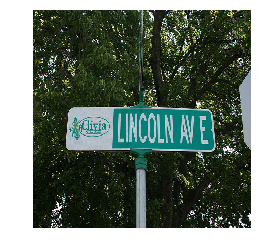

b'the name of the street is lincoln ave'


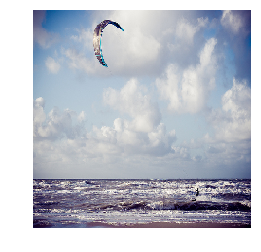

b'an ocean view including a man being pulled along by a water skiing parachute'


In [72]:
# Example of text query 
# text = 'two giraffes standing near trees'

# YOUR QUERY-1
text1 = sample_val_caption[2].decode('utf-8')
print(text1)

# DO NOT CHANGE BELOW CODE
search_image(text1)

a compartment that holds a fire hydrant hose


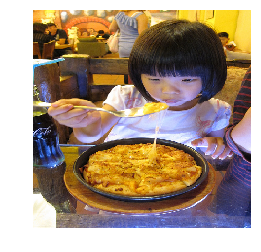

b'a little girl eating something out of a bowl with lots of cheese'


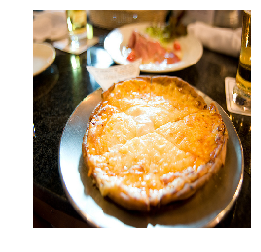

b'a pizza sitting on to of a white plate covered in cheese'


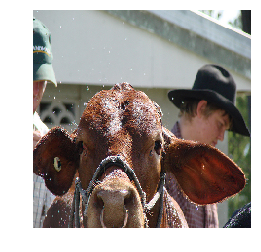

b'two men standing behind a cow in front of a house'


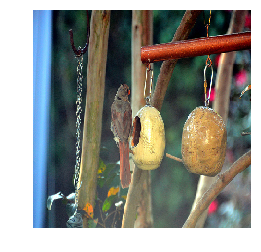

b'a small bird perches at the opening of a round hanging birdhouse'


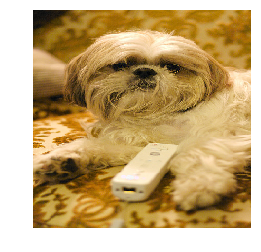

b'a dog sitting on furniture near nintendo wii remote'


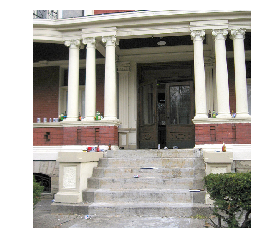

b'a picture of the entrance to an old house'


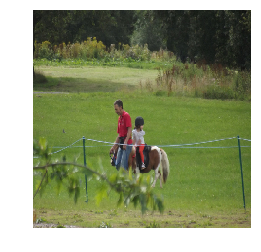

b'a man walks beside a girl on a horse'


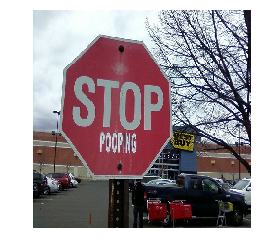

b'a red stop sign sitting on top of a metal pole'


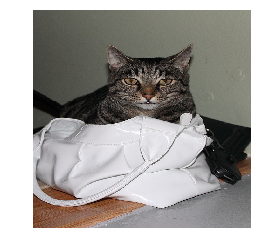

b'a striped cat sleeping on someones white purse'


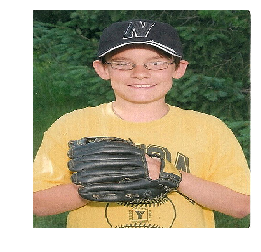

b'a young boy with glasses and a base ball glove'


In [77]:
# YOUR QUERY-2
text2 = sample_val_caption[8].decode('utf-8')
print(text2)

# DO NOT CHANGE BELOW CODE
search_image(text2)

Briefly discuss the result. Why or how it works, and why do you think it does not work at some point.

#### Answer:

=== write your answer here ===